1. Import i dane

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from nltk.stem import PorterStemmer, WordNetLemmatizer

nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

2. Czyszczenie tekstu i przetwarzanie

In [3]:
# Funkcje przetwarzające tekst
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www.\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def apply_stemming(text):
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))
    return " ".join([stemmer.stem(word) for word in text.split() if word not in stop_words])

def apply_lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words("english"))
    return " ".join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])


3. Wczytywanie i przygotowanie danych

In [5]:
df = pd.read_csv("/content/train.csv")
df = df.dropna(subset=["text"]).drop_duplicates()

df["clean_text"] = df["text"].apply(clean_text)
df["stemmed"] = df["clean_text"].apply(apply_stemming)
df["lemmatized"] = df["clean_text"].apply(apply_lemmatization)

# Zakodowanie etykiet jako liczby
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["Category"])


4. Balansowanie danych

In [6]:
def balance_dataframe(df, label_col, n_per_class):
    return df.groupby(label_col).apply(lambda x: x.sample(n=min(n_per_class, len(x)), random_state=42)).reset_index(drop=True)

df_balanced = balance_dataframe(df, "Category", 200)
df_balanced["label"] = label_encoder.transform(df_balanced["Category"])


/tmp/ipython-input-6-1177182587.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(label_col).apply(lambda x: x.sample(n=min(n_per_class, len(x)), random_state=42)).reset_index(drop=True)


5. Modele i ewaluacja krzyżowa

In [7]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

models = {
    "MultinomialNB": MultinomialNB(),
    "ComplementNB": ComplementNB(),
    "BernoulliNB": BernoulliNB(),
    "LogReg_l2": LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000),
    "LogReg_l1": LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000),
    "LinearSVC": LinearSVC(max_iter=1000),
    "SVC_rbf": SVC(kernel='rbf'),
    "SVC_poly": SVC(kernel='poly'),
    "RF_gini": RandomForestClassifier(criterion="gini", n_estimators=100, random_state=42),
    "RF_entropy": RandomForestClassifier(criterion="entropy", n_estimators=100, random_state=42)
}

def evaluate_models_cv(X_texts, y_labels, title_suffix):
    results = {}
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for name, model in models.items():
        pipeline = Pipeline([
            ("tfidf", TfidfVectorizer(max_features=5000)),
            ("clf", model)
        ])
        scores = cross_val_score(pipeline, X_texts, y_labels, cv=skf, scoring="accuracy", n_jobs=-1)
        results[name] = (scores.mean(), scores.std())
        print(f"{title_suffix} | {name} — Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")
    return results


6. Uruchomienie czwartej ewaluacji

In [11]:
results = {
    "Stemowane (pełne)": evaluate_models_cv(df["stemmed"], df["label"], "Stem-pełne"),
    "Lematyzowane (pełne)": evaluate_models_cv(df["lemmatized"], df["label"], "Lem-pełne"),
    "Stemowane (zbal.)": evaluate_models_cv(df_balanced["stemmed"], df_balanced["label"], "Stem-zbalansowane"),
    "Lematyzowane (zbal.)": evaluate_models_cv(df_balanced["lemmatized"], df_balanced["label"], "Lem-zbalansowane")
}


Stem-pełne | MultinomialNB — Accuracy: 0.8204 ± 0.0062
Stem-pełne | ComplementNB — Accuracy: 0.8771 ± 0.0095
Stem-pełne | BernoulliNB — Accuracy: 0.8295 ± 0.0073
Stem-pełne | LogReg_l2 — Accuracy: 0.8418 ± 0.0104
Stem-pełne | LogReg_l1 — Accuracy: 0.8231 ± 0.0149
Stem-pełne | LinearSVC — Accuracy: 0.8648 ± 0.0145
Stem-pełne | SVC_rbf — Accuracy: 0.8362 ± 0.0149
Stem-pełne | SVC_poly — Accuracy: 0.6475 ± 0.0118
Stem-pełne | RF_gini — Accuracy: 0.7996 ± 0.0164
Stem-pełne | RF_entropy — Accuracy: 0.8004 ± 0.0124
Lem-pełne | MultinomialNB — Accuracy: 0.8234 ± 0.0054
Lem-pełne | ComplementNB — Accuracy: 0.8763 ± 0.0071
Lem-pełne | BernoulliNB — Accuracy: 0.8268 ± 0.0107
Lem-pełne | LogReg_l2 — Accuracy: 0.8389 ± 0.0103
Lem-pełne | LogReg_l1 — Accuracy: 0.8201 ± 0.0099
Lem-pełne | LinearSVC — Accuracy: 0.8589 ± 0.0174
Lem-pełne | SVC_rbf — Accuracy: 0.8306 ± 0.0119
Lem-pełne | SVC_poly — Accuracy: 0.6390 ± 0.0099
Lem-pełne | RF_gini — Accuracy: 0.8028 ± 0.0128
Lem-pełne | RF_entropy — Accura

<ipython-input-14-1870110126>:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
<ipython-input-14-1870110126>:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')


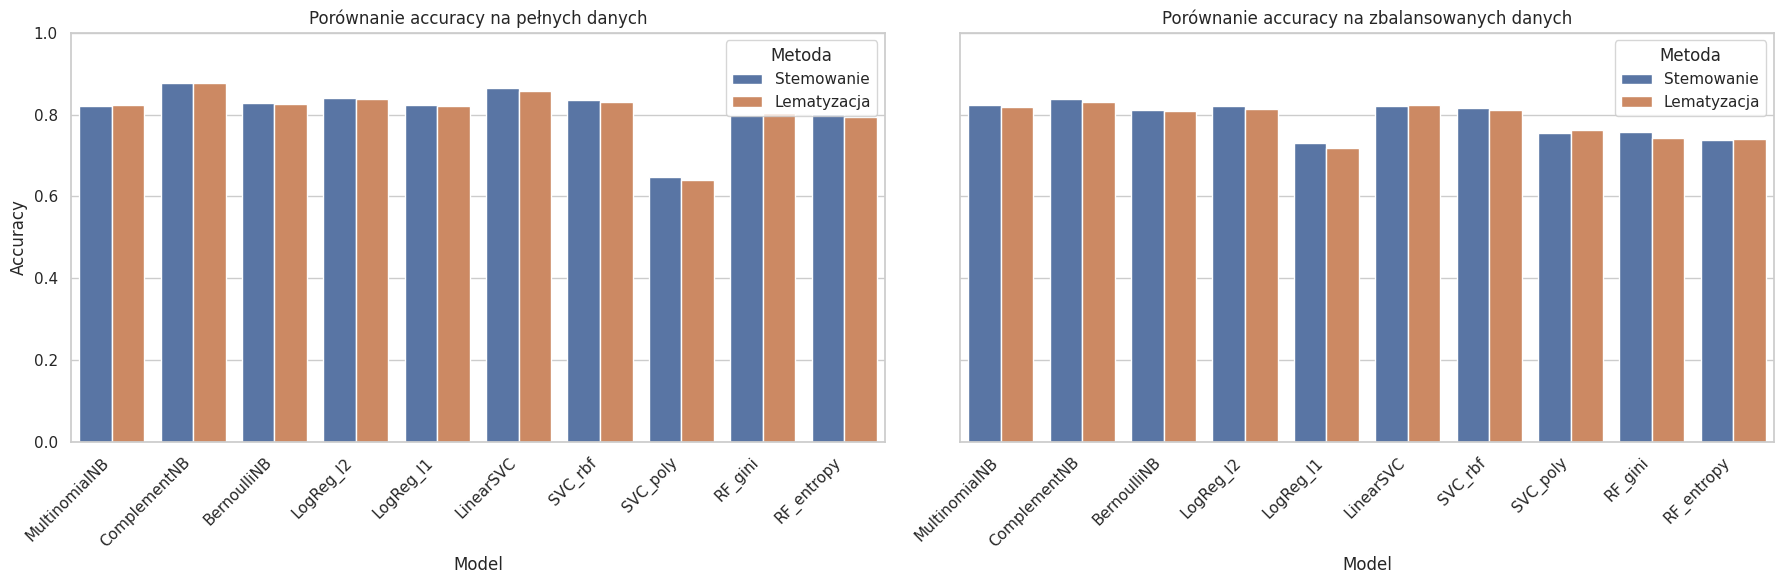

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_comparison(results_full_stem, results_full_lem, results_bal_stem, results_bal_lem):
    models_list = list(models.keys())

    # Przygotuj dane do DataFrame
    data = []
    for model in models_list:
        data.append({"Model": model, "Accuracy": results_full_stem[model][0], "Metoda": "Stemowanie", "Zbiór": "Pełne"})
        data.append({"Model": model, "Accuracy": results_full_lem[model][0], "Metoda": "Lematyzacja", "Zbiór": "Pełne"})
        data.append({"Model": model, "Accuracy": results_bal_stem[model][0], "Metoda": "Stemowanie", "Zbiór": "Zbalansowane"})
        data.append({"Model": model, "Accuracy": results_bal_lem[model][0], "Metoda": "Lematyzacja", "Zbiór": "Zbalansowane"})

    df_plot = pd.DataFrame(data)

    sns.set(style="whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

    sns.barplot(x="Model", y="Accuracy", hue="Metoda", data=df_plot[df_plot["Zbiór"]=="Pełne"], ax=axes[0])
    axes[0].set_title("Porównanie accuracy na pełnych danych")
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

    sns.barplot(x="Model", y="Accuracy", hue="Metoda", data=df_plot[df_plot["Zbiór"]=="Zbalansowane"], ax=axes[1])
    axes[1].set_title("Porównanie accuracy na zbalansowanych danych")
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

    for ax in axes:
        ax.set_ylim(0, 1)
        ax.set_ylabel("Accuracy")
        ax.legend(title="Metoda")

    plt.tight_layout()
    plt.show()

# Wywołanie funkcji z Twoimi wynikami
plot_comparison(
    results["Stemowane (pełne)"],
    results["Lematyzowane (pełne)"],
    results["Stemowane (zbal.)"],
    results["Lematyzowane (zbal.)"]
)



7. Wizualizacja porównania

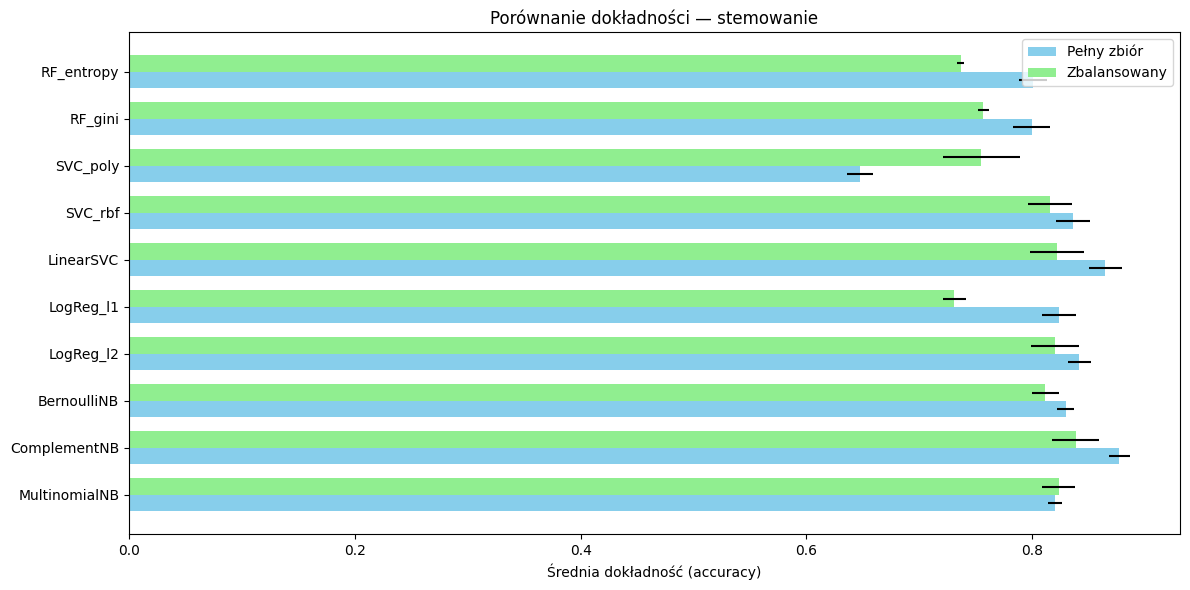

In [ ]:
#def plot_cv_results(results_dict):
#    for dataset_name, scores_dict in results_dict.items():
#        plt.figure(figsize=(10, 6))
#        models = list(scores_dict.keys())
#        means = [v[0] for v in scores_dict.values()]
#        stds = [v[1] for v in scores_dict.values()]

#        sns.barplot(x=means, y=models, xerr=stds, palette="viridis")
#        plt.title(f"Ewaluacja krzyżowa – {dataset_name}")
#        plt.xlabel("Średnia dokładność (± std)")
#        plt.xlim(0, 1)
#        for i, m in enumerate(means):
#            plt.text(m + 0.01, i, f"{m:.3f}", va="center")
#        plt.tight_layout()
#        plt.show()

# plot_cv_results(results)

def plot_comparison(results_full, results_bal, title):
    import matplotlib.pyplot as plt
    import numpy as np

    model_names = list(results_full.keys())
    means_full = [results_full[model][0] for model in model_names]
    stds_full = [results_full[model][1] for model in model_names]

    means_bal = [results_bal[model][0] for model in model_names]
    stds_bal = [results_bal[model][1] for model in model_names]

    x = np.arange(len(model_names))
    width = 0.35

    plt.figure(figsize=(12, 6))
    plt.barh(x - width/2, means_full, width, xerr=stds_full, label="Pełny zbiór", color="skyblue")
    plt.barh(x + width/2, means_bal, width, xerr=stds_bal, label="Zbalansowany", color="lightgreen")

    plt.yticks(x, model_names)
    plt.xlabel("Średnia dokładność (accuracy)")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_comparison(results["Stemowane (pełne)"], results["Stemowane (zbal.)"], "Porównanie dokładności — stemowanie")

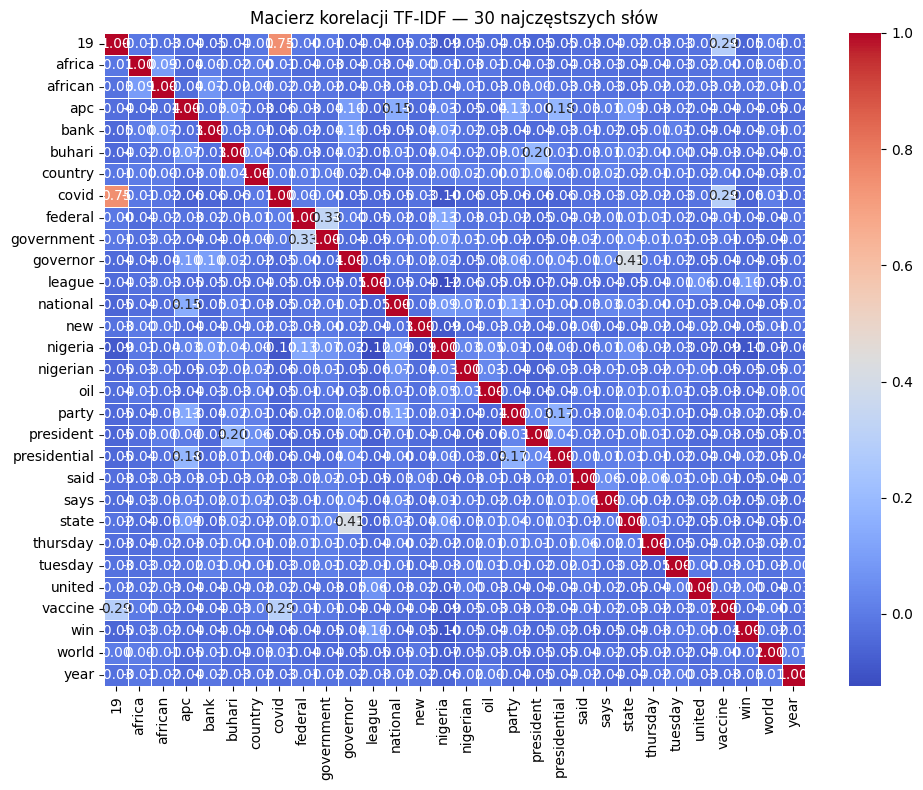

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

# Zakładamy, że masz DataFrame `df` z kolumną 'text'
# Wczytaj dane, np.:
# df = pd.read_csv("train.csv")

# Utwórz macierz TF-IDF (ograniczona do 30 najczęstszych słów)
vectorizer = TfidfVectorizer(max_features=30, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df["text"])
words = vectorizer.get_feature_names_out()

# Zamień na DataFrame i policz korelację
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=words)
corr_matrix = tfidf_df.corr()

# Tworzenie wykresu korelacji
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Macierz korelacji TF-IDF — 30 najczęstszych słów")
plt.tight_layout()

# Zapisz wykres
plt.savefig("correlation_matrix.png", dpi=300)
plt.show()

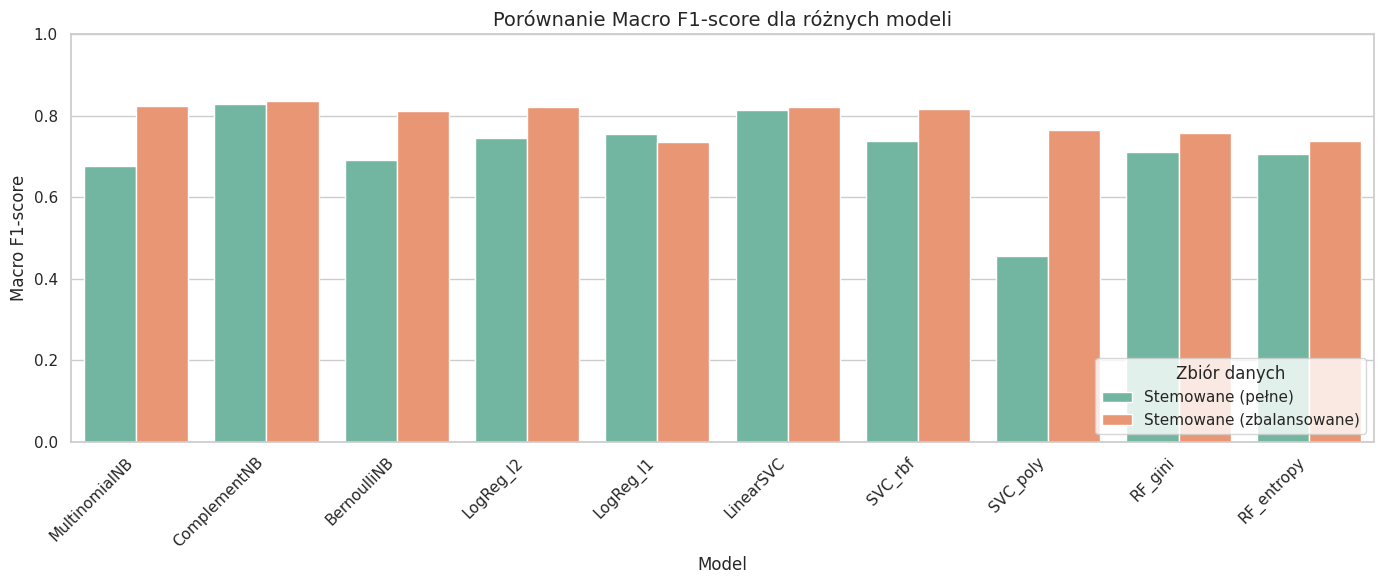

In [10]:
def evaluate_all_models_metrics(models, X_texts, y_labels, dataset_name=""):
    results = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for name, model in models.items():
        pipeline = Pipeline([
            ("tfidf", TfidfVectorizer(max_features=5000)),
            ("clf", model)
        ])

        y_pred = cross_val_predict(pipeline, X_texts, y_labels, cv=skf, n_jobs=-1)

        result = {
            "model": name,
            "dataset": dataset_name,
            "micro_precision": precision_score(y_labels, y_pred, average='micro'),
            "macro_precision": precision_score(y_labels, y_pred, average='macro'),
            "micro_recall": recall_score(y_labels, y_pred, average='micro'),
            "macro_recall": recall_score(y_labels, y_pred, average='macro'),
            "micro_f1": f1_score(y_labels, y_pred, average='micro'),
            "macro_f1": f1_score(y_labels, y_pred, average='macro')
        }

        results.append(result)

    return pd.DataFrame(results).round(4)
df_metrics_full = evaluate_all_models_metrics(models, df["stemmed"], df["label"], dataset_name="Stemowane (pełne)")
df_metrics_bal = evaluate_all_models_metrics(models, df_balanced["stemmed"], df_balanced["label"], dataset_name="Stemowane (zbalansowane)")
df_all_metrics = pd.concat([df_metrics_full, df_metrics_bal], ignore_index=True)
df_all_metrics.to_csv("macro_micro_model_comparison.csv", index=False)


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
sns.set(style="whitegrid")

# Rysujemy wykres słupkowy z podziałem na pełny i zbalansowany zbiór
sns.barplot(data=df_all_metrics, x="model", y="macro_f1", hue="dataset", palette="Set2")

plt.title("Porównanie Macro F1-score dla różnych modeli", fontsize=14)
plt.ylabel("Macro F1-score")
plt.xlabel("Model")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1.0)
plt.legend(title="Zbiór danych", loc="lower right")
plt.tight_layout()
plt.savefig("macro_f1_comparison_plot.png", dpi=300)
plt.show()
